In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Plotting packs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#NLP packs
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from textblob import TextBlob , Word
import re 
import string
import spacy
from tqdm.notebook import tqdm

##Wordcloud Modules
from wordcloud import WordCloud , STOPWORDS

#Machine learning Packs
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [3]:
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip',encoding = 'ISO-8859-1')
test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip',encoding = 'ISO-8859-1')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip',encoding = 'ISO-8859-1')
submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip',encoding = 'ISO-8859-1' )

In [4]:
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
49780,851b7d369ae66638,"""\n\nNo, I am not Kimes. As I have stated, I a...",0,0,0,0,0,0
35032,5d8d20eefadd8e14,I am going to shoot you in the head and laugh ...,1,1,0,1,0,0
122575,8fa3c0425d0cb47c,We aren't going to agree because you don't und...,0,0,0,0,0,0
145337,1b0eeecf73b04e86,If it wasnt murder than what was it?,0,0,0,0,0,0
150176,67dea5da48a601ed,do you have a life at all or do you just down ...,1,0,0,0,0,0


In [5]:
test.sample(5)

,id,comment_text
103516,acd155ec05ff40d3,"""::::As for your outspoken liberals, I'm defin..."
124425,cfd7d6e29fc56e19,i mean damm and fuck you
25033,29b7b4048ee02fbe,""" April 2012 (UTC) \n ::Yeah, I saw that. I wi..."
36412,3c7b424d2b63f1b9,":::Um. I considered your moves good-faith, if ..."
146069,f4314a4eaebb0a03,== Direct link to user's Talk page. == \n\n 30...


Aslinda test datasinin kullanilmayan kisimlari da var ancak kullanilmayan ksiimlar zaten score a etki etmeyecek bu yuzden cikarmaya greek yok

In [6]:
df = train.append(test)

In [7]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",NaN,NaN,NaN,NaN,NaN,NaN
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,NaN,NaN,NaN,NaN,NaN,NaN
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",NaN,NaN,NaN,NaN,NaN,NaN
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",NaN,NaN,NaN,NaN,NaN,NaN
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel...",NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [8]:
def clean_review_text(text):
    text = text.lower()  # covert the text to lowercase
    text = re.sub('<.*?>','',text).strip() # remove html chars
    text = re.sub('\[|\(.*\]|\)','', text).strip() # remove text in square brackets and parenthesis
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation marks
    text = re.sub("(\\W)"," ",text).strip() # remove non-ascii chars
    text = re.sub('\S*\d\S*\s*','', text).strip()  # remove words containing numbers
    return text.strip()

In [9]:
df['comment_text']=df['comment_text'].str.lower().str.replace('[^\w\s]','').str.replace('\d+','').str.replace('\n',' ').replace('\r','')
df['comment_text']=df['comment_text'].apply(clean_review_text)

In [10]:
from nltk.tokenize import word_tokenize
snow_stemmer = SnowballStemmer(language='english')
nlp = spacy.load('en_core_web_lg')

df['comment_text'] = df['comment_text'].apply(lambda x : word_tokenize(x.lower())) # cumle -> words
df["comment_text"] = df["comment_text"].apply(lambda x : [word for word in x if word not in set(nlp.Defaults.stop_words)]) # stop words cikarma
df["comment_text"] = df["comment_text"].apply(lambda x : [snow_stemmer.stem(word) for word in x]) # kelimelerin kok halleri
df["comment_text"] = df["comment_text"].apply(lambda x : " ".join(x)) # kelimleri birleştirdik

In [11]:
'''nlp = spacy.load('en_core_web_lg')
with nlp.disable_pipes():
    df_vec = np.array([nlp(text).vector for text in tqdm(df.comment_text)])'''

"nlp = spacy.load('en_core_web_lg')\nwith nlp.disable_pipes():\n    df_vec = np.array([nlp(text).vector for text in tqdm(df.comment_text)])"

### Data Visualization

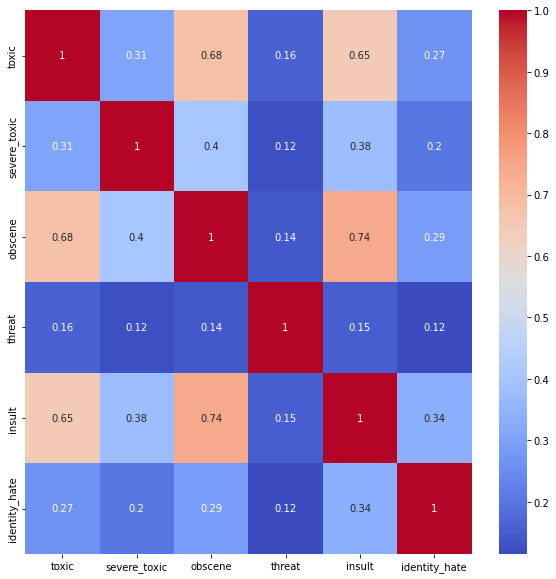

In [12]:
heatmap_data = train.iloc[:, -6:]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='coolwarm', annot=True)
ax.tick_params(labelsize=10)

### Vectorizer

In [13]:
word_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',ngram_range=(1, 3), stop_words='english',sublinear_tf=True)
df_dtm = word_vectorizer.fit_transform(df["comment_text"])

In [14]:
train_dtm = df_dtm[:train.shape[0]]
test_dtm = df_dtm[train.shape[0]:]

## Evaluation

In [15]:
X = train_dtm
y = train.iloc[:, -6:]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

lr = LogisticRegression(C=10, penalty='l2', solver='liblinear', random_state=4)
classifier_ovr = OneVsRestClassifier(lr)
classifier_ovr.fit(x_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10, random_state=4,
                                                 solver='liblinear'))

In [17]:
y_test_proba = classifier_ovr.predict_proba(x_test)

In [18]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
(mean_squared_error(y_test,y_test_proba))**0.5, r2_score(y_test,y_test_proba)

(0.12761398057030027, 0.3560267820049386)

## Training and Prediction

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

lr = LogisticRegression(C=10, penalty='l2', solver='liblinear', random_state=4)
classifier_ovr = OneVsRestClassifier(lr)
classifier_ovr.fit(X, y)

OneVsRestClassifier(estimator=LogisticRegression(C=10, random_state=4,
                                                 solver='liblinear'))

In [20]:
pred = classifier_ovr.predict_proba(test_dtm)

In [21]:
submission = pd.DataFrame(columns = train.columns)
submission.drop(columns='comment_text', inplace=True)
submission.loc[:, 'id'] = test['id']
submission.iloc[:, -6:] = pred
submission.to_csv('submission.csv', index = False)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.992984,0.061572,0.973541,0.009156,0.872076,0.089269
1,0000247867823ef7,0.005591,0.001875,0.00355,0.001025,0.005427,0.002021
2,00013b17ad220c46,0.01906,0.002521,0.007678,0.000903,0.009228,0.002081
3,00017563c3f7919a,0.002032,0.000912,0.001447,0.000526,0.001639,0.000589
4,00017695ad8997eb,0.018586,0.001227,0.005835,0.000656,0.007812,0.001289
